## Install dependencies

## Load CodeXGLUE Database for Defect detect

In [1]:
# Imports
import pandas as pd
from datasets import load_dataset

# Load dataset
ds = load_dataset("google/code_x_glue_cc_defect_detection")

# Convert to pandas for exploration
train_df = pd.DataFrame(ds["train"])
val_df = pd.DataFrame(ds["validation"])
test_df = pd.DataFrame(ds["test"])


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


## Data Exploration and Data Analysis
using pandas and matplotlib

In [2]:
# Quick look
print(train_df.head())
print(train_df.columns)
print(train_df["target"].value_counts(normalize=True))  # class balance


   id                                               func  target project  \
0   0  static av_cold int vdadec_init(AVCodecContext ...   False  FFmpeg   
1   1  static int transcode(AVFormatContext **output_...   False  FFmpeg   
2   2  static void v4l2_free_buffer(void *opaque, uin...   False  FFmpeg   
3   4  int av_opencl_buffer_write(cl_mem dst_cl_buf, ...   False  FFmpeg   
4   5  static int r3d_read_rdvo(AVFormatContext *s, A...    True  FFmpeg   

                                  commit_id  
0  973b1a6b9070e2bf17d17568cbaf4043ce931f51  
1  321b2a9ded0468670b7678b7c098886930ae16b2  
2  5d5de3eba4c7890c2e8077f5b4ae569671d11cf8  
3  57d77b3963ce1023eaf5ada8cba58b9379405cc8  
4  aba232cfa9b193604ed98f3fa505378d006b1b3b  
Index(['id', 'func', 'target', 'project', 'commit_id'], dtype='object')
target
False    0.541594
True     0.458406
Name: proportion, dtype: float64


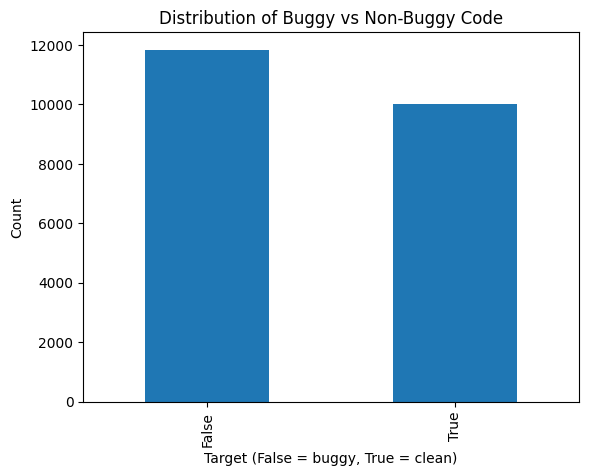

In [3]:
import matplotlib.pyplot as plt

train_df["target"].value_counts().plot(
    kind="bar",
    title="Distribution of Buggy vs Non-Buggy Code",
    xlabel="Target (False = buggy, True = clean)",
    ylabel="Count"
)
plt.show()


In [4]:
print("Example 1")
print(train_df.iloc[0]["func"])
print("Buggy:", train_df.iloc[0]["target"])


Example 1
static av_cold int vdadec_init(AVCodecContext *avctx)

{

    VDADecoderContext *ctx = avctx->priv_data;

    struct vda_context *vda_ctx = &ctx->vda_ctx;

    OSStatus status;

    int ret;



    ctx->h264_initialized = 0;



    /* init pix_fmts of codec */

    if (!ff_h264_vda_decoder.pix_fmts) {

        if (kCFCoreFoundationVersionNumber < kCFCoreFoundationVersionNumber10_7)

            ff_h264_vda_decoder.pix_fmts = vda_pixfmts_prior_10_7;

        else

            ff_h264_vda_decoder.pix_fmts = vda_pixfmts;

    }



    /* init vda */

    memset(vda_ctx, 0, sizeof(struct vda_context));

    vda_ctx->width = avctx->width;

    vda_ctx->height = avctx->height;

    vda_ctx->format = 'avc1';

    vda_ctx->use_sync_decoding = 1;

    vda_ctx->use_ref_buffer = 1;

    ctx->pix_fmt = avctx->get_format(avctx, avctx->codec->pix_fmts);

    switch (ctx->pix_fmt) {

    case AV_PIX_FMT_UYVY422:

        vda_ctx->cv_pix_fmt_type = '2vuy';

        break;

    case AV_PIX_FM

## Convert Dataset
converting the pandas dataframe to a huggingface dataset for training

In [5]:
from datasets import Dataset

train_df["target"] = train_df["target"].astype(int)
val_df["target"] = val_df["target"].astype(int)
test_df["target"] = test_df["target"].astype(int)
train_ds = Dataset.from_pandas(train_df)
val_ds = Dataset.from_pandas(val_df)
test_ds = Dataset.from_pandas(test_df)

In [6]:
print(pd.Series(train_df["target"]).value_counts())


target
0    11836
1    10018
Name: count, dtype: int64


## Tokenize Code

In [7]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")

def tokenize_and_prepare_labels(example):
    # Tokenize the code snippet
    tokens = tokenizer(
        example["func"],
        padding="max_length",
        truncation=True,
        max_length=256
    )
    # Convert True/False to integer labels
    tokens["labels"] = int(example["target"])
    return tokens

# Apply tokenization and label conversion
tokenized_train = train_ds.map(tokenize_and_prepare_labels)
tokenized_val   = val_ds.map(tokenize_and_prepare_labels)
tokenized_test  = test_ds.map(tokenize_and_prepare_labels)

#Set format for PyTorch
columns = ["input_ids", "attention_mask", "labels"]
tokenized_train.set_format("torch", columns=columns)
tokenized_val.set_format("torch", columns=columns)
tokenized_test.set_format("torch", columns=columns)

Map:   0%|          | 0/21854 [00:00<?, ? examples/s]

Map:   0%|          | 0/2732 [00:00<?, ? examples/s]

Map:   0%|          | 0/2732 [00:00<?, ? examples/s]

## Train and Evaluate CodeBert with CodeXGlUE

In [9]:
import transformers
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import torch

model = AutoModelForSequenceClassification.from_pretrained(
    "microsoft/codebert-base", num_labels=2
)

# -------------------------------
# Metric computation
# -----------------------------
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "precision": precision_score(labels, preds, zero_division=0),
        "recall": recall_score(labels, preds, zero_division=0),
        "f1": f1_score(labels, preds, zero_division=0),
        "accuracy": (preds == labels).mean()
    }

# -------------------------------
# Training arguments
# -------------------------------
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=10,            # longer training
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=5e-6,             # lower LR
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=50,
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

from transformers import TrainerCallback, TrainingArguments, TrainerState, TrainerControl
from torch.utils.data import DataLoader

class PredictionMonitorCallback(TrainerCallback):
    def on_epoch_end(self, args: TrainingArguments, state: TrainerState, control: TrainerControl, **kwargs):
        model.eval()
        val_loader = DataLoader(tokenized_val, batch_size=32)
        all_preds = []
        with torch.no_grad():
            for batch in val_loader:
                # Ensure batch is on the same device as the model
                batch = {k: v.to(model.device) for k, v in batch.items()}
                outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])
                preds = torch.argmax(outputs.logits, dim=-1)
                all_preds.extend(preds.cpu().numpy())
        counts = np.bincount(all_preds, minlength=2)
        print(f"\n[Epoch {state.epoch}] Predicted counts: 0 -> {counts[0]}, 1 -> {counts[1]}")
        model.train()

trainer.add_callback(PredictionMonitorCallback)
trainer.train()

results = trainer.evaluate(tokenized_test)
print("Test metrics:", results)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2351680940.py:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: Currently logged in as: jmitani4 (jmitani4-ucla) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.640200,0.619156,0.697917,0.225779,0.341184,0.621157
2,0.618100,0.606528,0.771831,0.230834,0.355383,0.636164
3,0.578500,0.587763,0.630952,0.446504,0.522940,0.646047
4,0.568500,0.596520,0.640531,0.447346,0.526786,0.650805



[Epoch 1.0] Predicted counts: 0 -> 2348, 1 -> 384

[Epoch 2.0] Predicted counts: 0 -> 2377, 1 -> 355

[Epoch 3.0] Predicted counts: 0 -> 1892, 1 -> 840

[Epoch 4.0] Predicted counts: 0 -> 1903, 1 -> 829


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.640200,0.619156,0.697917,0.225779,0.341184,0.621157
2,0.618100,0.606528,0.771831,0.230834,0.355383,0.636164
3,0.578500,0.587763,0.630952,0.446504,0.522940,0.646047
4,0.568500,0.596520,0.640531,0.447346,0.526786,0.650805
5,0.547700,0.602510,0.706667,0.357203,0.474538,0.656296
6,0.496300,0.607331,0.670051,0.444819,0.534684,0.663616
7,0.480800,0.674582,0.713333,0.360573,0.479015,0.659224
8,0.487100,0.647256,0.646432,0.511373,0.571025,0.666179
9,0.480700,0.667285,0.646632,0.525695,0.579926,0.669107
10,0.458600,0.684904,0.655902,0.496209,0.564988,0.668009



[Epoch 5.0] Predicted counts: 0 -> 2132, 1 -> 600

[Epoch 6.0] Predicted counts: 0 -> 1944, 1 -> 788

[Epoch 7.0] Predicted counts: 0 -> 2132, 1 -> 600

[Epoch 8.0] Predicted counts: 0 -> 1793, 1 -> 939

[Epoch 9.0] Predicted counts: 0 -> 1767, 1 -> 965

[Epoch 10.0] Predicted counts: 0 -> 1834, 1 -> 898


Test metrics: {'eval_loss': 0.6121382117271423, 'eval_precision': 0.6486486486486487, 'eval_recall': 0.4398406374501992, 'eval_f1': 0.5242165242165242, 'eval_accuracy': 0.6332357247437774, 'eval_runtime': 36.4505, 'eval_samples_per_second': 74.951, 'eval_steps_per_second': 4.691, 'epoch': 10.0}
